In [1]:
# import stan
import stan_jupyter as stan
import pyper
from plotnine import ggplot
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

r = pyper.R(use_pandas=True)

## Stanの基本的な書き方

In [2]:
model = """
    data {
        int N;
        real Y[N];
    }

    parameters {
        real mu;
    }

    model {
        for (n in 1:N) {
            Y[n] ~ normal(mu, 1);
        }
        mu ~ normal(0, 100);
    }
"""

## データ用意

In [3]:
# Python
data = pd.read_csv("../data/data-salary.txt")
display(data.head())
X = data.X.values
Y = data.Y.values
# R
r.assign("d", data)

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


## 単回帰分析

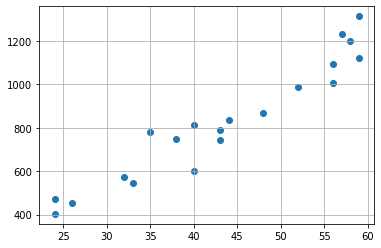

In [4]:
plt.scatter(X, Y)
plt.grid()
plt.show()

In [5]:
reg = LinearRegression().fit(X.reshape(-1, 1), Y)
reg.score(X.reshape(-1, 1), Y), reg.coef_, reg.intercept_

(0.9204126558540815, array([21.90420143]), -119.69713212134616)

In [6]:
print(r("""
res_lm <- lm(Y ~ X, data=d)
res_lm
"""))

try({
+ res_lm <- lm(Y ~ X, data=d)
+ res_lm
+ })

Call:
lm(formula = Y ~ X, data = d)

Coefficients:
(Intercept)            X  
     -119.7         21.9  




In [7]:
r("""
X_new <- data.frame(X=23:60)  # 23~60の値のシーケンスを生成
conf_95 <- predict(res_lm, X_new, interval='confidence', level=0.95)
pred_95 <- predict(res_lm, X_new, interval='prediction', level=0.95)
""")
print(r("head(conf_95, n = 5)"))
print(r("head(pred_95, n = 5)"))
X_new = r.get('X_new')
conf_95 = r.get('conf_95')
pred_95 = r.get('pred_95')


try({head(conf_95, n = 5)})
       fit      lwr      upr
1 384.0995 309.3077 458.8913
2 406.0037 333.9625 478.0449
3 427.9079 358.5797 497.2361
4 449.8121 383.1547 516.4695
5 471.7163 407.6822 535.7504

try({head(pred_95, n = 5)})
       fit      lwr      upr
1 384.0995 201.8638 566.3352
2 406.0037 224.8795 587.1279
3 427.9079 247.8456 607.9702
4 449.8121 270.7611 628.8631
5 471.7163 293.6253 649.8073



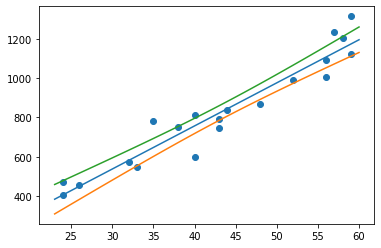

In [8]:
# 信頼区間について（後で読む）
# https://blog.statsbeginner.net/entry/2014/10/18/130504

sns.lineplot(x=X_new.values.reshape(-1), y=conf_95[:, 0].reshape(-1))
sns.lineplot(x=X_new.values.reshape(-1), y=conf_95[:, 1].reshape(-1))
sns.lineplot(x=X_new.values.reshape(-1), y=conf_95[:, 2].reshape(-1))
plt.scatter(X, Y)

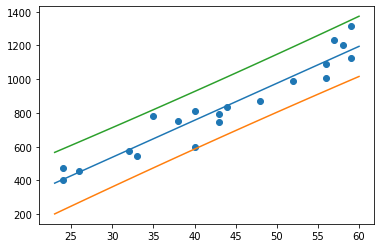

In [9]:
sns.lineplot(x=X_new.values.reshape(-1), y=pred_95[:, 0].reshape(-1))
sns.lineplot(x=X_new.values.reshape(-1), y=pred_95[:, 1].reshape(-1))
sns.lineplot(x=X_new.values.reshape(-1), y=pred_95[:, 2].reshape(-1))
plt.scatter(X, Y)

## PyStanで実行

In [10]:
model_code = """
data {
    int N;
    real X[N];
    real Y[N];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a + b*X[n], sigma);
    }
}
"""

stan_data = {
    "N": len(X),
    "X": X,
    "Y": Y,
}

posterior = stan.build(model_code, data=stan_data, random_seed=1234)
fit = posterior.sample()


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_bvf4t5m0/model_skia7wly.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_bvf4t5m0/model_skia7wly.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take

In [11]:
fit.to_frame().describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000
mean,-93.659657,0.930807,0.167229,3.472500,16.830000,0.0,95.169621,-119.845465,21.903422,85.147315
std,1.323125,0.103164,0.010713,1.005732,9.657661,0.0,1.798389,72.567371,1.622346,16.278957
min,-102.028584,0.085563,0.154738,1.000000,1.000000,0.0,92.089371,-447.304583,16.354962,50.156941
25%,-94.257813,0.910564,0.159345,3.000000,7.000000,0.0,93.856616,-167.136971,20.837569,73.526560
50%,-93.336177,0.971001,0.165502,4.000000,15.000000,0.0,94.810498,-118.755500,21.942098,82.805871
75%,-92.682152,0.994337,0.173387,4.000000,27.000000,0.0,96.160283,-74.038469,22.951768,93.847999
max,-92.030183,1.000000,0.183175,5.000000,39.000000,0.0,107.046646,111.143675,29.033627,180.865585


In [12]:
az.from_pystan(posterior=fit, posterior_model=posterior)

Inference data with groups:
	> posterior
	> sample_stats

In [13]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-119.845,72.567,-257.439,14.769,1.897,1.375,1469.0,1589.0,1.00
b,21.903,1.622,18.661,24.732,0.042,0.030,1470.0,1560.0,1.00
sigma,85.147,16.279,56.626,114.814,0.437,0.313,1445.0,1489.0,1.01


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

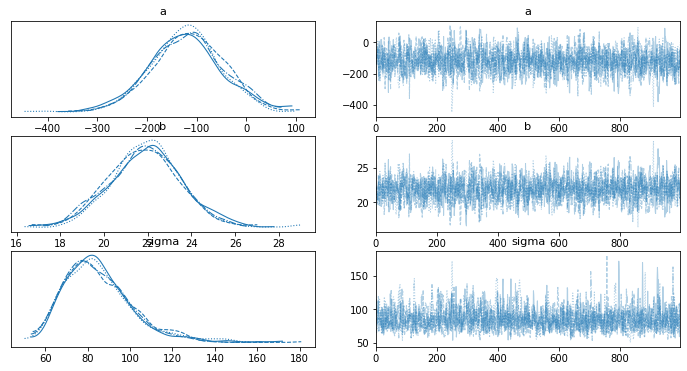

In [14]:
az.plot_trace(fit)

## MCMCの設定変更

num_thin: スキップする数

https://mc-stan.org/docs/2_29/cmdstan-guide/mcmc-config.html#

```
Argument thin controls the number of draws from the posterior written to the output file. Some users familiar with older approaches to MCMC sampling might be used to thinning to eliminate an expected autocorrelation in the samples. HMC is not nearly as susceptible to this autocorrelation problem and thus thinning is generally not required nor advised, as HMC can produce anticorrelated draws, which increase the effective sample size beyond the number of draws from the posterior. Thinning should only be used in circumstances where storage of the samples is limited and/or RAM for later processing the samples is limited.
```

In [15]:
fit2 = posterior.sample(num_chains=3, num_samples=1000, num_warmup=100, num_thin=1)

Sampling:   0%
Sampling:   3% (101/3300)
Sampling:   6% (202/3300)
Sampling:   9% (303/3300)
Sampling:  15% (502/3300)
Sampling:  24% (801/3300)
Sampling:  33% (1100/3300)
Sampling:  42% (1400/3300)
Sampling:  55% (1800/3300)
Sampling:  70% (2300/3300)
Sampling:  85% (2800/3300)
Sampling:  94% (3100/3300)
Sampling: 100% (3300/3300)
Sampling: 100% (3300/3300), done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
           three stages of adaptation as currently configured.
           Reducing each adaptation stage to 15%/75%/10% of
           the given number of warmup iterations:
             init_buffer = 15
             adapt_window = 75
             term_buffer = 10
  Gradient evaluation took 6e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
  Adjust your expectations accordingly!
   

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

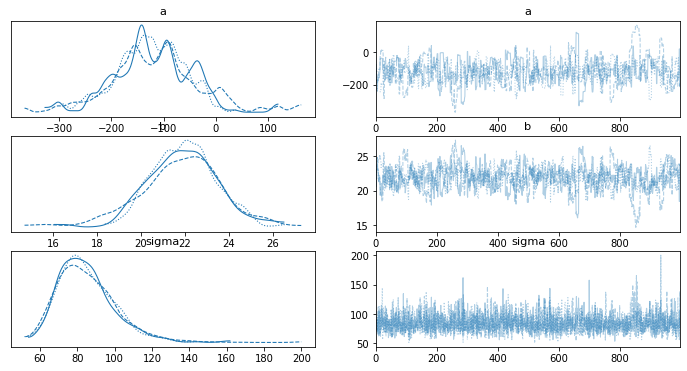

In [16]:
az.plot_trace(fit2)

## 並列計算

In [17]:
# fit3 = posterior.sample(num_chains=3, num_samples=1000, num_warmup=1000, num_thin=1, num_threads=2)

## ベイズ信頼区間とベイズ予測区間の算出

In [18]:
df = fit.to_frame()

In [19]:
df.quantile([0.025, 0.975])

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,a,b,sigma
0.025,-97.135201,0.619241,0.154738,2.0,3.0,0.0,92.675352,-263.443642,18.789630,60.910116
0.975,-92.142997,1.000000,0.183175,5.0,31.0,0.0,99.606269,22.243626,25.157987,124.836650


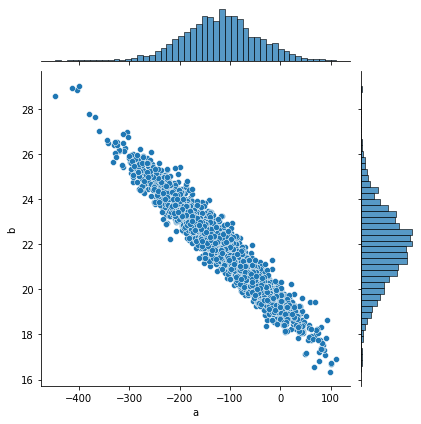

In [20]:
sns.jointplot(x='a', y='b', data=df)
plt.show()

In [21]:
def mcmc_samples(df, age):
    n_mcmc = df.shape[0]
    sigma = df['sigma'].values
    avg = df['a'].values + df['b'].values * age
    y = np.random.normal(avg, sigma, size=n_mcmc)
    return y

In [22]:
x = list(range(23, 61))
results = np.zeros((df.shape[0], len(x)))
for i, age in enumerate(x):
    results[:, i:i+1] = mcmc_samples(df, age=age).reshape(-1, 1)

In [23]:
df_res = pd.DataFrame(results, columns=x)
df_conf = df_res.quantile([0.025, 0.975])
df_conf

,23,24,25,26,27,28,29,30,31,32,...,51,52,53,54,55,56,57,58,59,60
0.025,207.396220,227.632525,245.241814,272.782700,284.978369,298.694632,325.230495,357.740108,382.806130,402.367011,...,818.879460,845.025618,856.453382,887.558383,899.496274,929.916473,951.939547,967.947361,991.771549,1010.544592
0.975,568.991611,589.180356,620.218376,629.258491,654.785508,669.346878,694.994490,722.803506,743.819214,763.895491,...,1179.477781,1203.130782,1222.468311,1241.547229,1263.068340,1289.946896,1310.027774,1334.008342,1357.849301,1384.779227


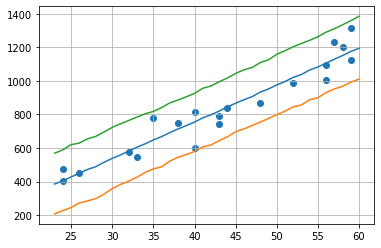

In [24]:
plt.plot(x, df_res.mean())
plt.plot(x, df_conf.loc[0.025, :].values)
plt.plot(x, df_conf.loc[0.975, :].values)
plt.scatter(X, Y)
plt.grid()
plt.show()

## 4.4.12  transformed parametersブロックとgenerated quantitiesブロック

In [25]:
model_code = """
data {
    int N;
    real X[N];
    real Y[N];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a + b*X[n], sigma);
    }
}
"""

stan_data = {
    "N": len(X),
    "X": X,
    "Y": Y,
}

posterior = stan.build(model_code, data=stan_data, random_seed=1234)
fit = posterior.sample()


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_bvf4t5m0/model_skia7wly.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_bvf4t5m0/model_skia7wly.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions usi

In [26]:
model_code = """
data {
    int N;
    real X[N];
    real Y[N];
    int N_new;
    real X_new[N_new];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

transformed parameters {
    real y_base[N];
    for (n in 1:N) {
        y_base[n] = a + b*X[n];
    }
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(y_base[n], sigma);
    }
}

generated quantities {
    real y_base_new[N_new];
    real y_new[N_new];
    for (n in 1:N_new) {
        y_base_new[n] = a +b*X_new[n];
        y_new[n] = normal_rng(y_base_new[n], sigma);
    }
}
"""

X_new = list(range(23, 60))
stan_data = {
    "N": len(X),
    "X": X,
    "Y": Y,
    "N_new": len(X_new),
    "X_new": X_new,
}

posterior = stan.build(model_code, data=stan_data, random_seed=1234)
fit = posterior.sample()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_5kcgmspy/model_zskdtd26.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_5kcgmspy/model_zskdtd26.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_5kcgmspy/model_zskdtd26.stan', line 7, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [27]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-119.731,73.720,-263.229,18.839,1.988,1.455,1395.0,1446.0,1.00
b,21.901,1.643,18.801,25.024,0.044,0.032,1387.0,1471.0,1.00
sigma,84.699,15.601,57.510,112.654,0.401,0.289,1533.0,1546.0,1.01
y_base[0],405.903,37.071,331.317,472.964,0.945,0.669,1562.0,1682.0,1.00
y_base[1],405.903,37.071,331.317,472.964,0.945,0.669,1562.0,1682.0,1.00
...,...,...,...,...,...,...,...,...,...
y_new[32],1085.414,90.927,905.735,1251.492,1.465,1.036,3884.0,3368.0,1.00
y_new[33],1103.936,90.897,942.606,1285.465,1.504,1.064,3644.0,3817.0,1.00
y_new[34],1130.048,91.432,957.852,1297.464,1.515,1.072,3635.0,3841.0,1.00
y_new[35],1149.249,91.621,978.668,1325.711,1.475,1.046,3872.0,3752.0,1.00


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'y_base'}>,
        <AxesSubplot:title={'center':'y_base'}>],
       [<AxesSubplot:title={'center':'y_base_new'}>,
        <AxesSubplot:title={'center':'y_base_new'}>],
       [<AxesSubplot:title={'center':'y_new'}>,
        <AxesSubplot:title={'center':'y_new'}>]], dtype=object)

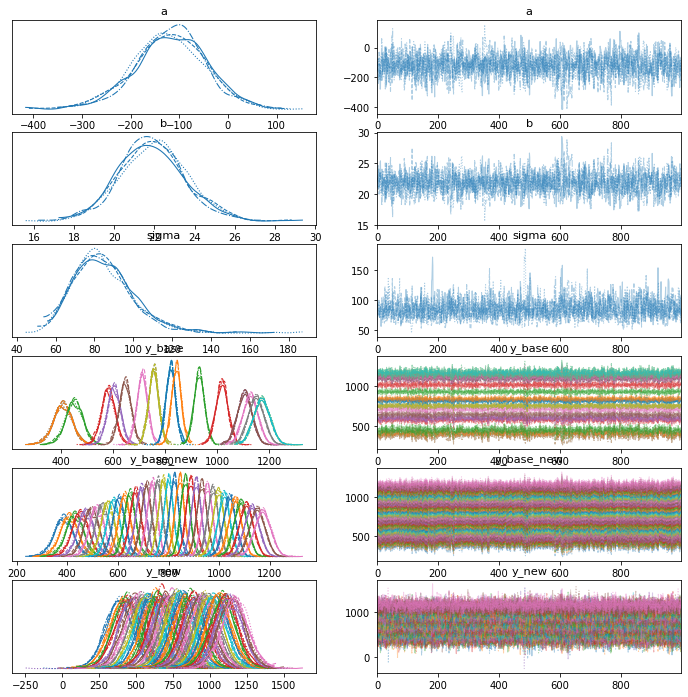

In [28]:
az.plot_trace(fit)

## 練習問題

In [29]:
np.random.seed(1234)
N1 = 30
N2 = 20
Y1 = np.random.normal(0, 5, N1)  # mean=0, sd=5
Y2 = np.random.normal(1, 4, N2)  # mean=1, sd=4

(1) 各グループの値に差が認められるか。おおよそ把握するために図を描け。

/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


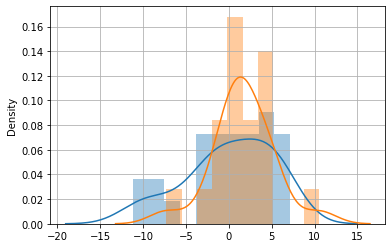

In [41]:
sns.distplot(Y1, bins=10)
sns.distplot(Y2, bins=10)
plt.grid()
plt.show()

In [31]:
model_code = """
data {
    int N1;
    int N2;
    real Y1[N1];
    real Y2[N2];
    int N1_new;
    int N2_new;
}

parameters {
    real mu1;
    real mu2;
    real<lower=0> sigma;
}

model {
    mu1 ~ normal(0, 100);
    mu2 ~ normal(0, 100);
    sigma ~ normal(0, 100);
    for (n1 in 1:N1) {
        Y1[n1] ~ normal(mu1, sigma);
    }
    for (n2 in 1:N2) {
        Y2[n2] ~ normal(mu2, sigma);
    }
}

generated quantities {
    real Y1_new[N1_new];
    real Y2_new[N2_new];
    for (n1 in 1:N1_new) {
        Y1_new[n1] = normal_rng(mu1, sigma);
    }
    for (n2 in 1:N2_new) {
        Y2_new[n2] = normal_rng(mu2, sigma);
    }
}
"""

N_new = 1

stan_data = {
    "N1": N1,
    "N2": N2,
    "Y1": Y1,
    "Y2": Y2,
    "N1_new": N_new,
    "N2_new": N_new,
}

posterior = stan.build(model_code, data=stan_data, random_seed=1234)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_3w59f256/model_qeprjj6t.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_3w59f256/model_qeprjj6t.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_3w59f256/model_qeprjj6t.stan', line 30, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-forma

In [32]:
fit = posterior.sample()

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 6.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.25 seconds.
  Adjust your expectations accordingly!


In [33]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.038,0.862,-1.543,1.708,0.014,0.013,3836.0,2711.0,1.0
mu2,1.700,1.092,-0.272,3.770,0.019,0.015,3194.0,2605.0,1.0
sigma,4.720,0.490,3.887,5.686,0.009,0.006,3193.0,2527.0,1.0
Y1_new[0],0.020,4.790,-8.396,9.606,0.074,0.054,4242.0,3961.0,1.0
Y2_new[0],1.581,4.837,-7.762,10.439,0.076,0.055,4040.0,4015.0,1.0


array([[<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'mu2'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'Y1_new'}>,
        <AxesSubplot:title={'center':'Y1_new'}>],
       [<AxesSubplot:title={'center':'Y2_new'}>,
        <AxesSubplot:title={'center':'Y2_new'}>]], dtype=object)

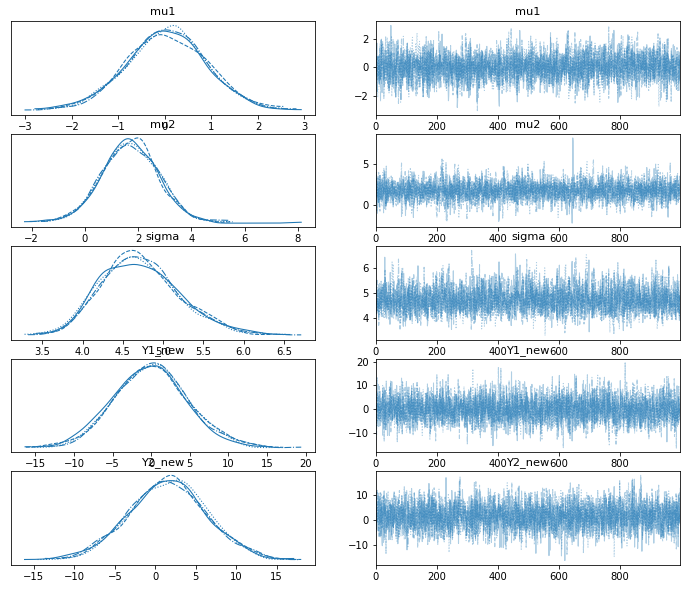

In [34]:
az.plot_trace(fit)

(4) 得られたMCMCサンプルから$Prob[\mu_1 < \mu_2]$ を計算せよ。

In [35]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu1,mu2,sigma,Y1_new.1,Y2_new.1
draws,,,,,,,,,,,,
0,-99.080024,0.802148,0.765041,2.0,3.0,0.0,102.242649,0.701287,1.653577,4.714487,-10.438893,-2.728944
1,-101.416323,0.619602,0.782033,2.0,3.0,0.0,104.523138,1.391054,3.168894,5.246947,1.689438,11.642613
2,-100.098046,0.968653,0.689733,3.0,7.0,0.0,100.202946,0.618211,0.200139,4.481122,-13.246939,-1.032332
3,-100.524093,1.000000,0.675082,3.0,7.0,0.0,102.384557,-0.414479,2.652275,5.435156,3.746383,8.145938
4,-101.927621,0.681433,0.765041,2.0,3.0,0.0,102.975247,0.804161,3.692310,5.514736,1.423419,9.228204


In [36]:
prob = (df["mu1"] < df["mu2"]).mean()
prob

0.88425

(5) 標準偏差が異なる場合をモデル式で表現せよ。

In [37]:
model_code = """
data {
    int N1;
    int N2;
    real Y1[N1];
    real Y2[N2];
    int N1_new;
    int N2_new;
}

parameters {
    real mu1;
    real mu2;
    real<lower=0> sigma1;
    real<lower=0> sigma2;
}

model {
    mu1 ~ normal(0, 100);
    mu2 ~ normal(0, 100);
    sigma1 ~ normal(0, 100);
    sigma2 ~ normal(0, 100);
    for (n1 in 1:N1) {
        Y1[n1] ~ normal(mu1, sigma1);
    }
    for (n2 in 1:N2) {
        Y2[n2] ~ normal(mu2, sigma2);
    }
}

generated quantities {
    real Y1_new[N1_new];
    real Y2_new[N2_new];
    for (n1 in 1:N1_new) {
        Y1_new[n1] = normal_rng(mu1, sigma1);
    }
    for (n2 in 1:N2_new) {
        Y2_new[n2] = normal_rng(mu2, sigma2);
    }
}
"""

N_new = 1

stan_data = {
    "N1": N1,
    "N2": N2,
    "Y1": Y1,
    "Y2": Y2,
    "N1_new": N_new,
    "N2_new": N_new,
}

posterior = stan.build(model_code, data=stan_data, random_seed=1234)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_u58ncfdz/model_f2j7phus.stan', line 5, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_u58ncfdz/model_f2j7phus.stan', line 6, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_u58ncfdz/model_f2j7phus.stan', line 32, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-forma

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.21 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!


array([[<AxesSubplot:title={'center':'mu1'}>,
        <AxesSubplot:title={'center':'mu1'}>],
       [<AxesSubplot:title={'center':'mu2'}>,
        <AxesSubplot:title={'center':'mu2'}>],
       [<AxesSubplot:title={'center':'sigma1'}>,
        <AxesSubplot:title={'center':'sigma1'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'Y1_new'}>,
        <AxesSubplot:title={'center':'Y1_new'}>],
       [<AxesSubplot:title={'center':'Y2_new'}>,
        <AxesSubplot:title={'center':'Y2_new'}>]], dtype=object)

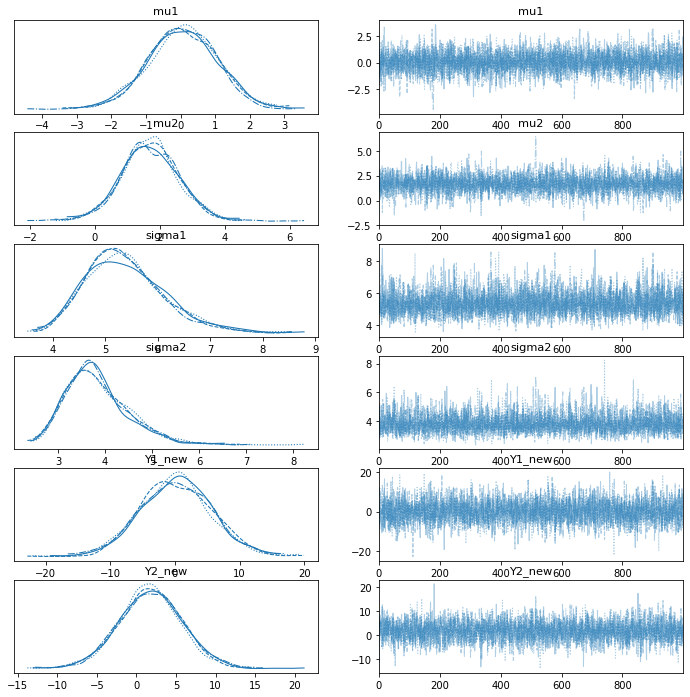

In [38]:
fit = posterior.sample()
az.plot_trace(fit)

In [39]:
df = fit.to_frame()
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu1,mu2,sigma1,sigma2,Y1_new.1,Y2_new.1
draws,,,,,,,,,,,,,
0,-96.704027,0.963050,0.655841,3.0,7.0,0.0,97.138127,1.044325,2.126603,5.708348,3.590355,2.678114,5.885137
1,-97.875892,1.000000,0.639472,2.0,3.0,0.0,101.564934,-0.356414,2.413817,6.016227,4.681010,-12.266737,-4.033620
2,-99.452216,0.758374,0.611780,2.0,3.0,0.0,100.658431,-0.679158,1.822526,4.703794,2.524734,-8.070060,1.856520
3,-98.293556,0.823961,0.719152,2.0,3.0,0.0,101.838270,0.601300,3.489541,4.965943,4.223152,2.837713,4.830895
4,-97.121044,0.922711,0.655841,3.0,7.0,0.0,98.140319,-1.390839,2.053540,5.054878,3.630826,0.339282,7.405475


In [40]:
prob = (df["mu1"] < df["mu2"]).mean()
prob

0.88725